## Notebook for tests using Ebner data (QDot, T - HTC)

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import os, sys
from sklearn.model_selection import train_test_split
from stareg.star_model import StarModel


### load data

In [2]:
path = "..\\..\\Data\\Table_alpha_Data.txt"
df = pd.read_csv(filepath_or_buffer=path)
df.columns = ["QDot", "T", "HTC"]

### preprocessing and train-test-split

In [3]:
# train test split
df_train, df_test = train_test_split(df, train_size=0.75)
# get transformation parameters
df_min, df_max = df_train.min(), df_train.max()
df_mean, df_std = df_train.mean(), df_train.std()
# min-max scale and standardize data
df_train[["QDot_norm", "T_norm"]] = (df_train[["QDot", "T"]] - df_min[["QDot", "T"]]) / (df_max[["QDot", "T"]] - df_min[["QDot", "T"]])
df_test[["QDot_norm", "T_norm"]] = (df_test[["QDot", "T"]] - df_min[["QDot", "T"]]) / (df_max[["QDot", "T"]] - df_min[["QDot", "T"]])
df_train["HTC_std"] = (df_train["HTC"] - df_mean["HTC"]) / df_std["HTC"]
df_test["HTC_std"] = (df_test["HTC"] - df_mean["HTC"]) / df_std["HTC"]
# get numpy arrays
X_train, y_train = df_train[["QDot_norm", "T_norm"]].values, df_train["HTC_std"].values
X_test, y_test = df_test[["QDot_norm", "T_norm"]].values, df_test["HTC_std"].values


def retransform(X, y, df_min=df_min, df_max=df_max, df_mean=df_mean, df_std=df_std):
    # retransform the given data in X and y
    df = pd.DataFrame(data={"QDot": X[:,0], "T": X[:,1], "HTC": y})
    df_retransformed = pd.DataFrame(columns=["QDot", "T", "HTC"])
    df_retransformed[["QDot", "T"]] = df_min[["QDot", "T"]] + df[["QDot", "T"]] * (df_max[["QDot", "T"]] - df_min[["QDot", "T"]])
    df_retransformed["HTC"] = df_mean["HTC"] + df["HTC"]*df_std["HTC"]
    return df_retransformed

C:\Users\WeberJ\Anaconda3\envs\thesis\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\WeberJ\Anaconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\WeberJ\Anaconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

### model defintion

In [108]:
m = ( ("s(1)", "inc", 64, (10, 6000), "equidistant"), 
    #  ("s(2)", "peak", 64, (10, 6000), "equidistant"), 
      ("t(1,2)", "smooth", (18,18), (5, 6000), "equidistant"), )
#m = (("t(1,2)", "smooth", (18,18), (10, 6000), "equidistant"), )
M = StarModel(description=m)


### fit

In [109]:
M.fit(X=X_train, y=y_train, plot_=0, cp=p)
print("MSE_train = ", M.mse)
metric = M.eval_metric(X=X_test, y=y_test)
print("Metric = ", metric)
print("MSPE = ", M.MSPE(X=X_test, y=y_test))

MSE_train =  0.2899903
Metric =  0.54878
MSPE =  0.30403


### plot

In [110]:
# create values for the plot of original values and predictions
nplot = 25
xplot = np.linspace(0,1,nplot)
xplotgrid = np.meshgrid(xplot, xplot)
Xplot = np.vstack((xplotgrid[0].ravel(), xplotgrid[1].ravel())).T
yplot = M.predict(X=Xplot)

df_re = retransform(X=np.vstack((X_train, p[:,:-1])), y=M.basis @ M.coef_)
df_surface_re = retransform(X=Xplot, y=M.predict(X=Xplot))

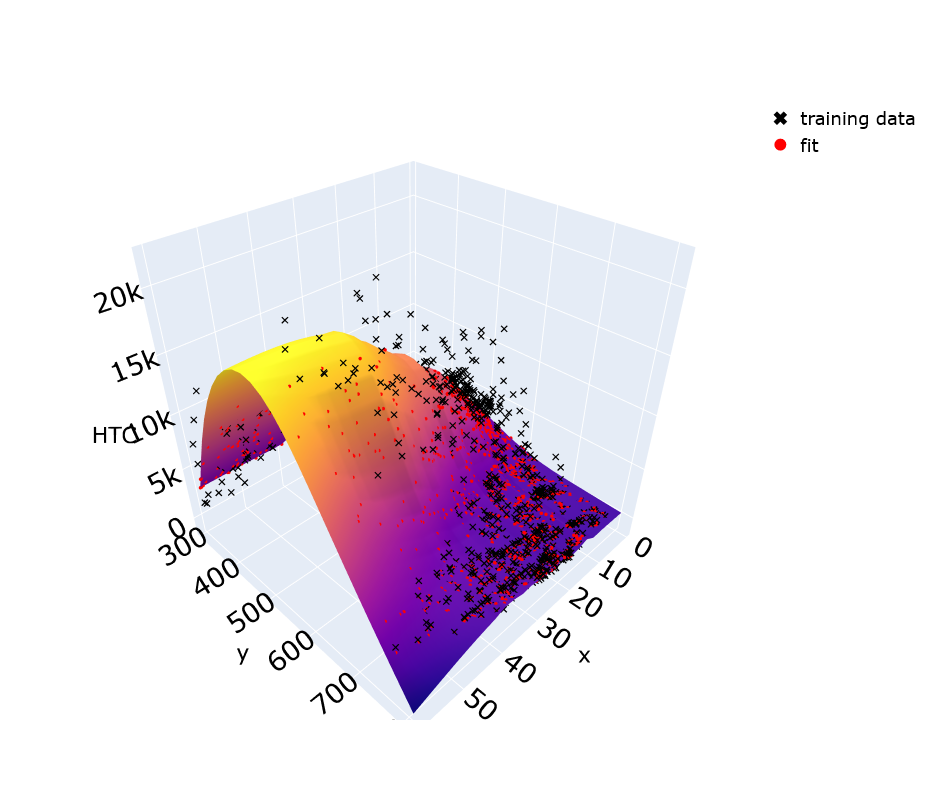

In [114]:
fig = go.Figure()
#fig.add_trace(go.Scatter3d(x=df["QDot"], y=df["T"], z=df["HTC"], mode="markers", marker=dict(size=2, color="black", symbol="x")))
fig.add_trace(go.Scatter3d(x=df_train["QDot"], y=df_train["T"], z=df_train["HTC"], mode="markers", marker=dict(size=2, color="black", symbol="x"), name="training data"))
fig.add_trace(go.Scatter3d(x=df_re["QDot"], y=df_re["T"], z=df_re["HTC"], mode="markers", marker=dict(size=2, color="red"), name="fit"))
# fig.add_trace(go.Mesh3d(x=Xplot[:,0], y=Xplot[:,1], z=yplot, name="fit", opacity=0.4, color="red"))
fig.add_trace(go.Surface(x=df_surface_re["QDot"].values.reshape(nplot, nplot), 
                         y=df_surface_re["T"].values.reshape(nplot, nplot),
                         z=df_surface_re["HTC"].values.reshape(nplot, nplot), 
                         showscale=False))
# fig.add_trace(go.Scatter3d(x=p[:,0], y=p[:,1], z=p[:,2], mode="markers", marker=dict(size=12, color="green")))
fig.layout.scene.zaxis.title = "HTC"
fig.update_layout(xaxis_title="QDot",
                  yaxis_title="T",
                  font=dict(size=18,color="black"))
fig.layout.legend.itemsizing = "constant"
fig.update_layout(height=800, width=800)

In [112]:
# plot individual parts
z_s1 = M.smooths["s(1)"].basis @ M.smooths["s(1)"].coef_
#z_s2 = M.smooths["s(2)"].basis @ M.smooths["s(2)"].coef_
z_t12 = M.smooths["t(1,2)"].basis @ M.smooths["t(1,2)"].coef_

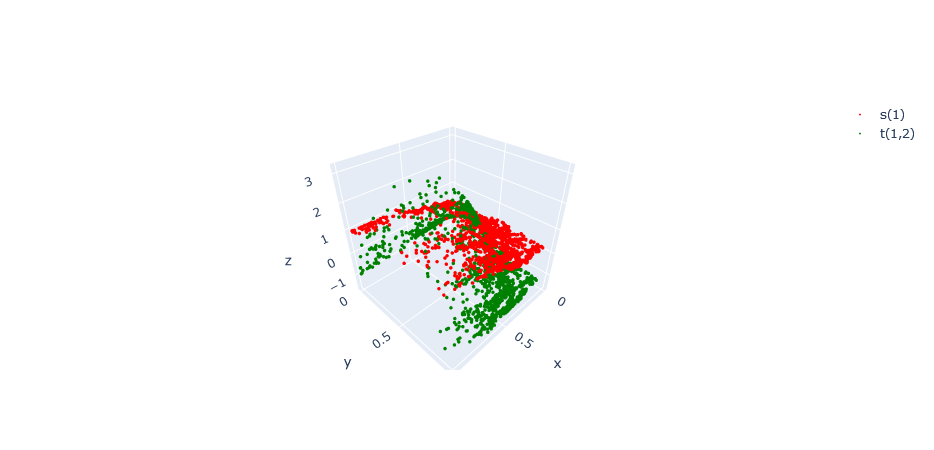

In [113]:
fig = go.Figure()
#fig.add_trace(go.Surface(x=xgrid, y=ygrid, z=zgrid))
#fig.add_trace(go.Scatter3d(x=xgrid.ravel(), y=ygrid.ravel(), z=zgrid.ravel(), mode="markers", marker=dict(size=2, color="black", symbol="x"), name="data"))
fig.add_trace(go.Scatter3d(x=X_train[:,0], y=X_train[:,1], z=z_s1, mode="markers", marker=dict(size=2, color="red"), name="s(1)"))
#fig.add_trace(go.Scatter3d(x=X_train[:,0], y=X_train[:,1], z=z_s2, mode="markers", marker=dict(size=2, color="blue"), name="s(2)"))
fig.add_trace(go.Scatter3d(x=X_train[:,0], y=X_train[:,1], z=z_t12, mode="markers", marker=dict(size=2, color="green"), name="t(1,2)"))
fig.show()

fig.update_layout(xaxis_title="QDot",
                  yaxis_title="T",
                  font=dict(size=18,color="black"))
fig.layout.legend.itemsizing = "constant"
fig.update_layout(height=700, width=1000)
fig.write_html("img/Fit_partition_ebner.html")

(1680,)

In [127]:
y_train = np.append(y_train, np.zeros(10))

In [136]:
df_mean["HTC"]

3172.961113934929

In [141]:
v = (((y_train*df_mean["HTC"]) / df_mean["HTC"]) < 0).astype(int)
sum(v) / len(v)

0.6946745562130178

In [130]:
# positivity constraint:
#    y >= 0

M.coef_.T @ M.basis.T @ np.diag(v) @ M.basis @ M.coef_


315.63424129546934

In [185]:
fig.write_html("img/Ebner_realValues"+".html")

### Create artificial data: $f(x, y) = \exp(\frac{-(y - y.mean)^2}{0.01*y.std}) + 0.2*x + \text{normalNoise}$

In [6]:
def f(x, y, noiselevel=0.05):   
    z =  y.max()*np.exp(-(y - y.mean())**2 / 0.01*y.std()) + 0.2*x + np.random.normal(size=x.shape) * np.mean([x.mean(), y.mean()]) * noiselevel
    return z

# create some data
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
xgrid, ygrid = np.meshgrid(x, y)
zgrid = f(xgrid, ygrid, noiselevel=0.1)

# create the dataset
X = np.vstack((xgrid.ravel(), ygrid.ravel())).T
y = zgrid.ravel()

# create a model and fit it
m = ( ("s(1)", "inc", 20, (0.1, 1000), "equidistant"), 
      ("s(2)", "peak", 20, (0.1, 1000), "equidistant") )
M2 = StarModel(description=m)
M2.fit(X=X, y=y, plot_=0)
print("MSE = ", M2.mse)
print("Metric = ", M2.eval_metric(X=X, y=y))

MSE =  0.0025002
Metric =  0.00765


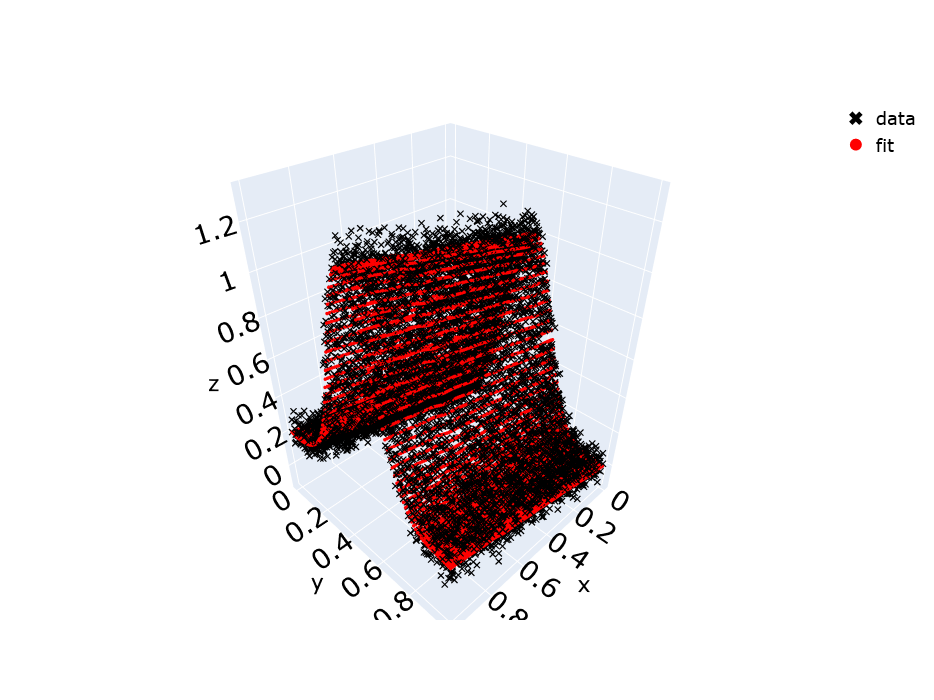

In [7]:
fig = go.Figure()
#fig.add_trace(go.Surface(x=xgrid, y=ygrid, z=zgrid))
fig.add_trace(go.Scatter3d(x=xgrid.ravel(), y=ygrid.ravel(), z=zgrid.ravel(), mode="markers", marker=dict(size=2, color="black", symbol="x"), name="data"))
fig.add_trace(go.Scatter3d(x=X[:,0], y=X[:,1], z=M2.basis @ M2.coef_, mode="markers", marker=dict(size=2, color="red"), name="fit"))
fig.update_layout(xaxis_title="QDot",
                  yaxis_title="T",
                  font=dict(size=18,color="black"))
fig.layout.legend.itemsizing = "constant"
fig.update_layout(height=700, width=800)

### Create artificial data: $f(x, y) = \exp(\frac{-(y - y.mean)^2}{0.01*y.std}) + 0.1*x + 0.5*x*y + \text{normalNoise}$ using Splines

In [8]:
def f(x, y, noiselevel=0.05):   
    z =  y.max()*np.exp(-(y - y.mean())**2 / 0.01*y.std()) + 0.1*x + 0.5*x*y + np.random.normal(size=x.shape) * np.mean([x.mean(), y.mean()]) * noiselevel
    return z

# create some data
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
xgrid, ygrid = np.meshgrid(x, y)
zgrid = f(xgrid, ygrid, noiselevel=0.1)

# create the dataset
X = np.vstack((xgrid.ravel(), ygrid.ravel())).T
y = zgrid.ravel()

In [9]:
# create a model and fit it
m = ( ("s(1)", "inc", 20, (0.1, 1000), "equidistant"), 
      ("s(2)", "peak", 20, (0.1, 1000), "equidistant") )
M2 = StarModel(description=m)
M2.fit(X=X, y=y, plot_=0)
print("MSE = ", M2.mse)
print("Metric = ", M2.eval_metric(X=X, y=y))

MSE =  0.0043898
Metric =  0.00994


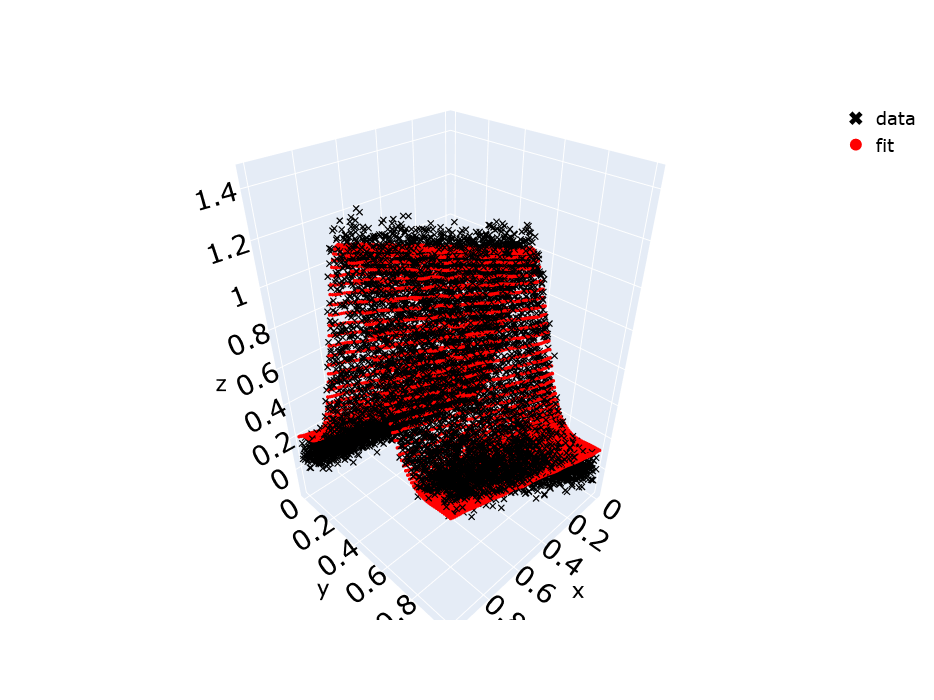

In [10]:
fig = go.Figure()
#fig.add_trace(go.Surface(x=xgrid, y=ygrid, z=zgrid))
fig.add_trace(go.Scatter3d(x=xgrid.ravel(), y=ygrid.ravel(), z=zgrid.ravel(), mode="markers", marker=dict(size=2, color="black", symbol="x"), name="data"))
fig.add_trace(go.Scatter3d(x=X[:,0], y=X[:,1], z=M2.basis @ M2.coef_, mode="markers", marker=dict(size=2, color="red"), name="fit"))
fig.update_layout(xaxis_title="QDot",
                  yaxis_title="T",
                  font=dict(size=18,color="black"))
fig.layout.legend.itemsizing = "constant"
fig.update_layout(height=700, width=800)

### Create artificial data: $f(x, y) = \exp(\frac{-(y - y.mean)^2}{0.01*y.std}) + 0.1*x + + 0.5*x*y + \text{normalNoise}$ using TPS and Splines

In [73]:
def f(x, y, noiselevel=0.05):   
    z =  y.max()*np.exp(-(y - y.mean())**2 / 0.01*y.std()) + 0.1*x + 0.5*x*y + np.random.normal(size=x.shape) * np.mean([x.mean(), y.mean()]) * noiselevel
    return z

# create some data
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
xgrid, ygrid = np.meshgrid(x, y)
zgrid = f(xgrid, ygrid, noiselevel=0.05)

In [74]:
# create the dataset
X = np.vstack((xgrid.ravel(), ygrid.ravel())).T
y = zgrid.ravel()

# create a model and fit it
m = ( ("s(1)", "inc", 20, (0.1, 1000), "equidistant"), 
      ("s(2)", "peak", 20, (0.1, 1000), "equidistant"),
      ("t(1,2)", "smooth", (5,5), (0.1, 1000), "equidistant") )

In [75]:
M2 = StarModel(description=m)
M2.fit(X=X, y=y, plot_=0)
print("MSE = ", M2.mse)
print("Metric = ", M2.eval_metric(X=X, y=y))

MSE =  0.0006157
Metric =  0.19443


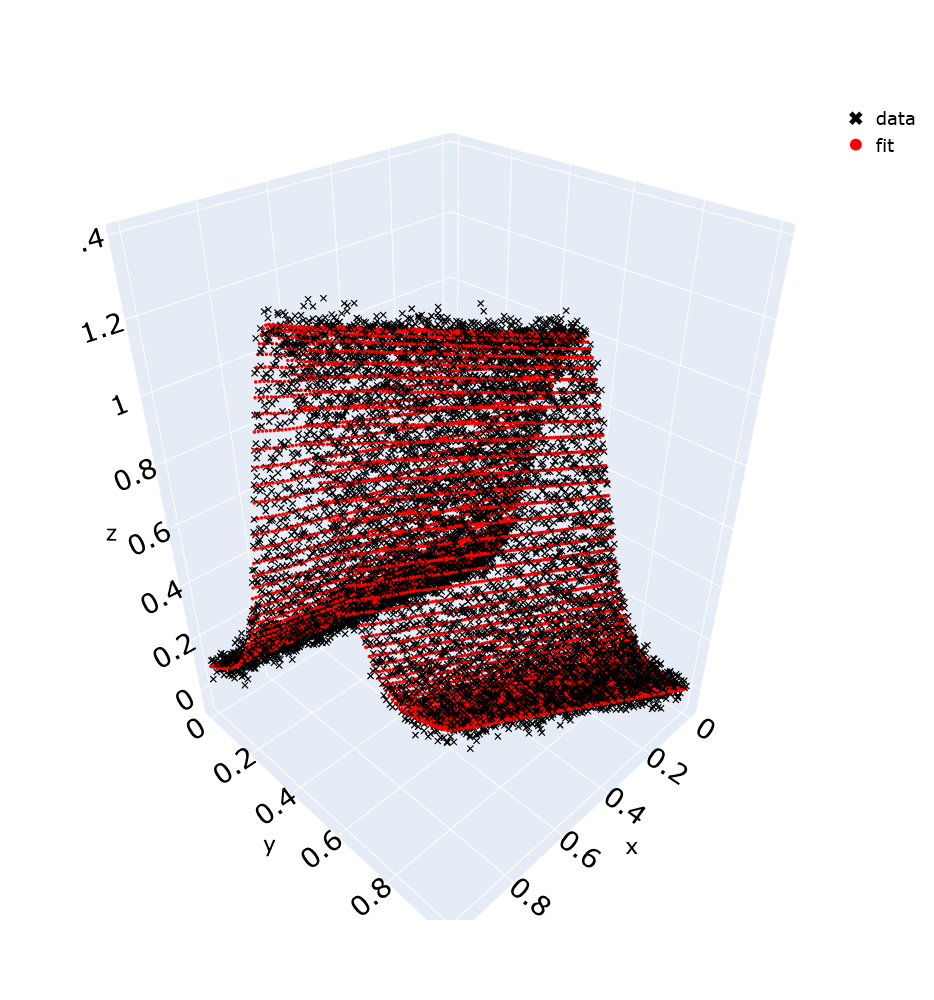

In [76]:
fig = go.Figure()
#fig.add_trace(go.Surface(x=xgrid, y=ygrid, z=zgrid))
fig.add_trace(go.Scatter3d(x=xgrid.ravel(), y=ygrid.ravel(), z=zgrid.ravel(), mode="markers", marker=dict(size=2, color="black", symbol="x"), name="data"))
fig.add_trace(go.Scatter3d(x=X[:,0], y=X[:,1], z=M2.basis @ M2.coef_, mode="markers", marker=dict(size=2, color="red"), name="fit"))
fig.update_layout(xaxis_title="QDot",
                  yaxis_title="T",
                  font=dict(size=18,color="black"))
fig.layout.legend.itemsizing = "constant"
fig.update_layout(height=1000, width=1000)

In [80]:
# plot individual parts
z_s1 = M2.smooths["s(1)"].basis @ M2.smooths["s(1)"].coef_
z_s2 = M2.smooths["s(2)"].basis @ M2.smooths["s(2)"].coef_
z_t12 = M2.smooths["t(1,2)"].basis @ M2.smooths["t(1,2)"].coef_

fig = go.Figure()
#fig.add_trace(go.Surface(x=xgrid, y=ygrid, z=zgrid))
fig.add_trace(go.Scatter3d(x=xgrid.ravel(), y=ygrid.ravel(), z=zgrid.ravel(), mode="markers", marker=dict(size=2, color="black", symbol="x"), name="data"))
fig.add_trace(go.Scatter3d(x=X[:,0], y=X[:,1], z=z_s1, mode="markers", marker=dict(size=2, color="red"), name="s(1)"))
fig.add_trace(go.Scatter3d(x=X[:,0], y=X[:,1], z=z_s2, mode="markers", marker=dict(size=2, color="blue"), name="s(2)"))
fig.add_trace(go.Scatter3d(x=X[:,0], y=X[:,1], z=z_t12, mode="markers", marker=dict(size=2, color="green"), name="t(1,2)"))

fig.update_layout(xaxis_title="QDot",
                  yaxis_title="T",
                  font=dict(size=18,color="black"))
fig.layout.legend.itemsizing = "constant"
fig.update_layout(height=700, width=1000)
fig.write_html("img/Fit_partition.html")